In [1]:
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from copy import deepcopy

base_path = '/Users/freezylex/Documents/course_work/'

# RVI

In [2]:
rvi = pd.read_csv(os.path.join(base_path, 'data/raw_data/RVI.txt'), delimiter = ';', decimal = ',')[::-1]
rvi.head(2)

,BOARDID,SECID,TRADEDATE,SHORTNAME,NAME,CLOSE,OPEN,HIGH,LOW,VALUE,DURATION,YIELD,DECIMALS,CAPITALIZATION,CURRENCYID,DIVISOR,TRADINGSESSION,VOLUME
244,RTSI,RVI,2015-03-02,Индекс RVI,Индекс волатильности RVI,51.39,50.32,53.48,50.31,0,NaN,NaN,2,0,NaN,NaN,3,NaN
243,RTSI,RVI,2015-03-03,Индекс RVI,Индекс волатильности RVI,51.26,51.25,53.13,51.17,0,NaN,NaN,2,0,NaN,NaN,3,NaN


In [3]:
rvi = rvi[['TRADEDATE', 'CLOSE']]
rvi.columns = ['Date', 'RVI']
rvi['Date'] = pd.to_datetime(rvi['Date'], format = '%Y-%m-%d')
rvi.reset_index(drop=True, inplace=True)
rvi.set_index('Date', inplace=True)
rvi.head(2)

,RVI
Date,
2015-03-02,51.39
2015-03-03,51.26


#### Upload target

In [4]:
rates = pd.read_excel(base_path + 'data/final_target.xlsx',
                      index_col = 'Date', parse_dates=True)
rates.drop(columns=['SU26217RMFS', 'SU26218RMFS'], inplace=True)
rates.head(2)

,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,SU26210RMFS,SU26211RMFS,SU26212RMFS
Date,,,,,,,,,,,,,
2015-03-02,-71.009402,-16.198293,-51.672678,213.214039,8.877833,-69.514138,81.363229,81.611366,-44.294101,-46.555882,-65.581271,-32.632524,103.025743
2015-03-03,7.255880,45.041981,17.967756,263.188637,62.406383,10.363783,125.481830,112.795674,22.874165,26.012453,9.625523,34.752162,129.932953


In [5]:
df = rates.reset_index().merge(rvi.reset_index(), on='Date', how='inner') #Join for future graphs
df.head(1)

,Date,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,SU26210RMFS,SU26211RMFS,SU26212RMFS,RVI
0,2015-03-02,-71.009402,-16.198293,-51.672678,213.214039,8.877833,-69.514138,81.363229,81.611366,-44.294101,-46.555882,-65.581271,-32.632524,103.025743,51.39


In [6]:
df_train, df_test = df.set_index('Date').loc['2015-06-01':'2016-01'].reset_index(), \
                    df.set_index('Date').loc['2016-02-01':].reset_index()

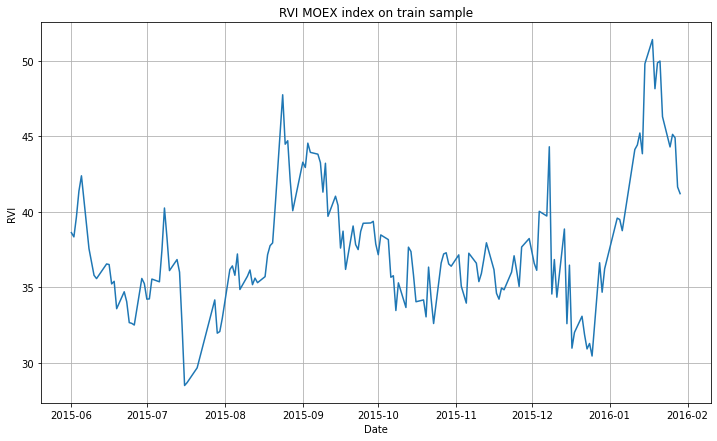

In [10]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(x = df_train['Date'], y = df_train['RVI'])
plt.title('RVI MOEX index on train sample')
plt.grid()
plt.savefig(os.path.join(base_path, 'graphs/RVI_index.png'), dpi=300)

- Just as in the USDRUB variable, we except structural break in the beginning of the 2016: it is known that most stocks and MOEX dropped significantly since 2016-01 due to oil price decrease and russian ruble decrease. News: https://www.finam.ru/news/headline0000F/padenie-nefti-ne-ostavilo-rossiiyskomu-rynku-shansov-na-rost-i-obvalilo-rubl-do-novyx-istoricheskix-minimumov-k-dollaru-20160120-202025/ 
- What happened in the middle of the January is stabilization of USDRUB which was mentioned in the USDRUB notebook. Due to that, stock market also started stabilizing and RVI index stopped growing up since investors had more clear vision of the future: http://www.finmarket.ru/analytics/4208184?utm_source=yxnews&utm_medium=desktop&utm_referrer=https%3A%2F%2Fyandex.ru%2Fnews%2Fsearch%3Ftext%3D

### Plot for structural break

In [11]:
def make_plot_for_gen(df, factor, factor_col, hue_date=None):
    fig, ax = plt.subplots(2, 7, figsize=(30, 20))
    min_ = df.values.ravel().min()
    max_ = df.values.ravel().max()
    if hue_date:
        h = pd.Series(index = factor.index, data = np.zeros(shape=factor.shape[0]))
        h.loc[hue_date:] = 1
    else:
        h = None
    i = 0
    for col in df.columns:
        if i < 7:
            sns.scatterplot(x = factor[factor_col],y = df[col], ax = ax[0, i], hue = h)
            ax[0, i].set_ylim([min_ - 0.1, max_ + 0.1])
        else:
            sns.scatterplot(x = factor[factor_col], y = df[col], ax = ax[1, i-7], hue = h)
            ax[1, i-7].set_ylim([min_ - 0.1, max_ + 0.1])
        i += 1

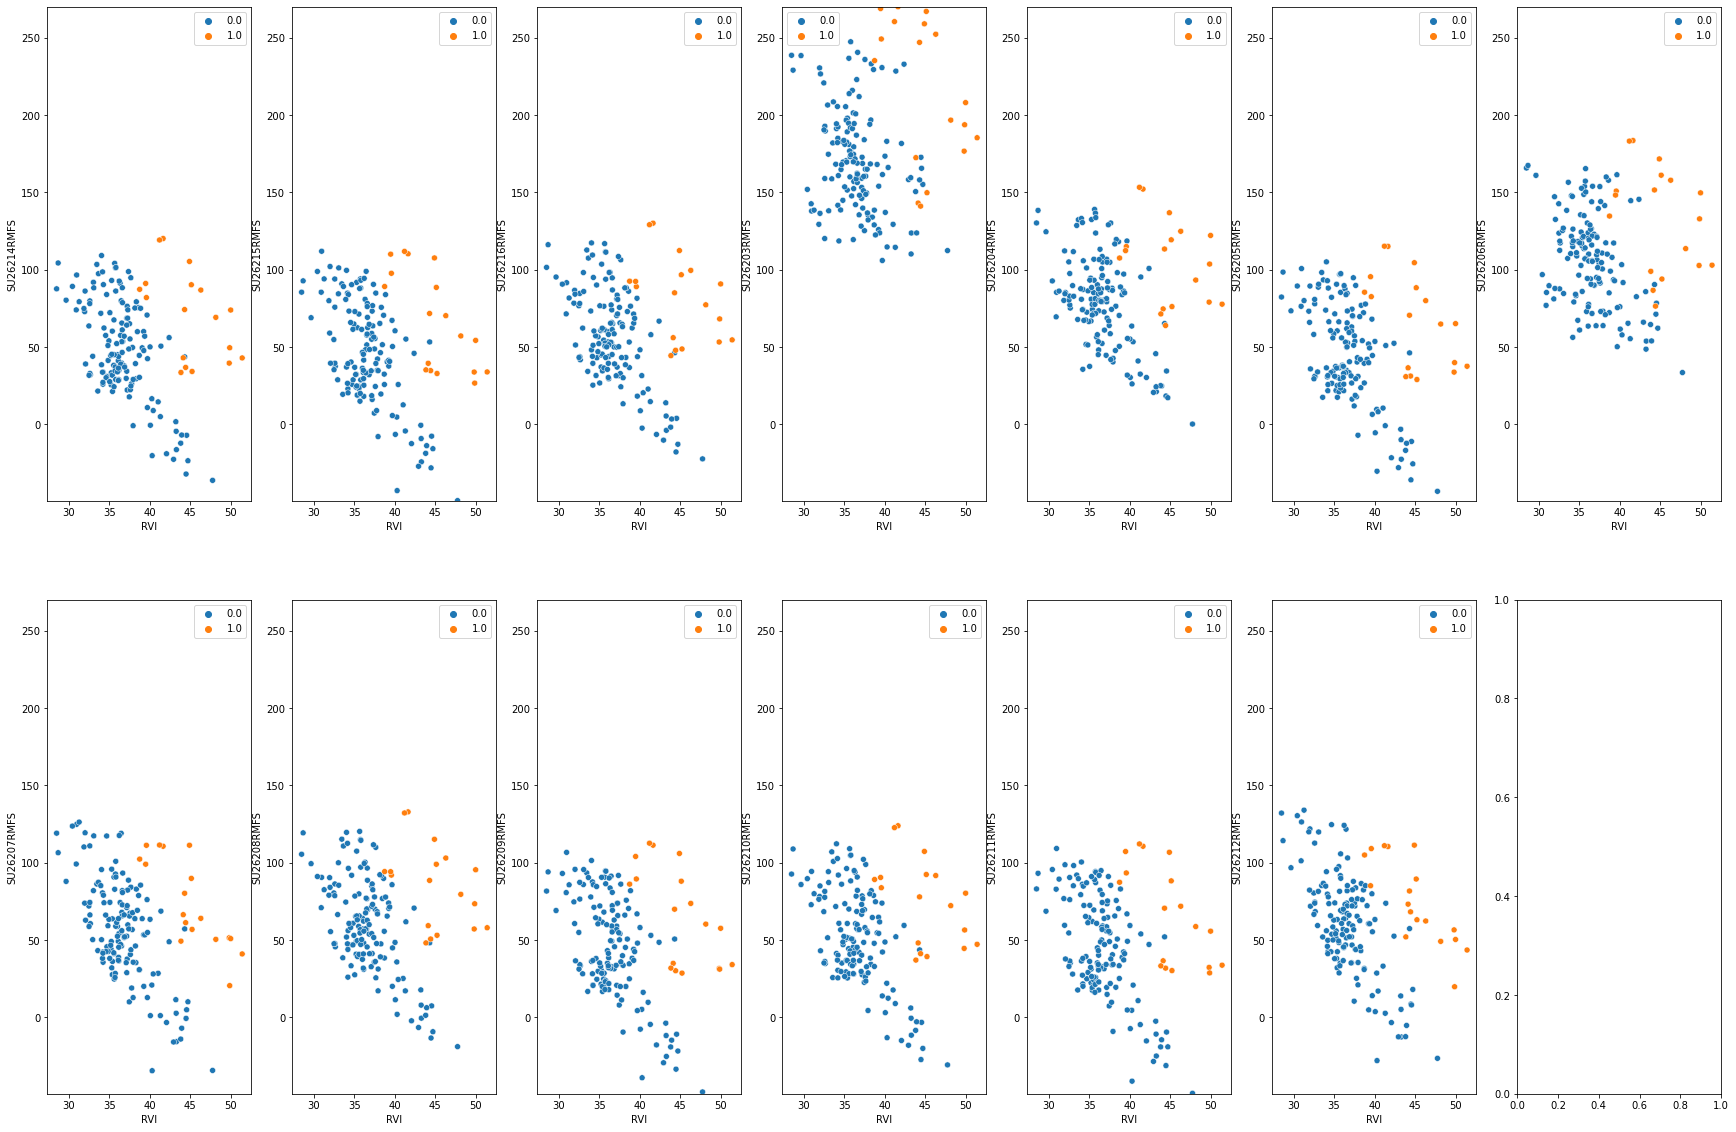

In [12]:
make_plot_for_gen(rates.loc['2015-06-01':'2016-01'], 
                  rvi.loc['2015-06-01':'2016-01'], 'RVI','2016-01-04')

- Based on the assumptions and evidence from the USDRUB variable research and also additional RVI research, it would make sense to introduce a dummy variable depicting this break since 2016-01-04. This point in time shows when oil prices, stock market and USВRUB started plummeting. 
- We will apply this break for both train and test sample

In [13]:
rvi['struct_coef'] = 0
rvi['dummy_struct_change'] = 0
rvi.loc['2016-01-04':].loc[:, 'struct_coef'] = 1 
rvi.loc['2016-01-04':].loc[:, 'dummy_struct_change'] = 1
rvi['struct_coef'] = rvi['struct_coef'] * rvi['RVI']
rvi.tail(7)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,RVI,struct_coef,dummy_struct_change
Date,,,
2016-02-11,48.13,48.13,1
2016-02-12,47.39,47.39,1
2016-02-15,46.81,46.81,1
2016-02-16,45.31,45.31,1
2016-02-17,43.18,43.18,1
2016-02-18,43.22,43.22,1
2016-02-19,41.84,41.84,1


In [14]:
rvi.to_csv(os.path.join(base_path, 'data/metrics_final/rvi.csv'))

## Additional research

### Idea


- Let's look at the plot of the coefficients of the regression $target = \alpha + \beta * rvi$

In [15]:
dict_with_coefs = {}
min_num_ob = 10
for bond in rates.columns:
    x = df['RVI'].values
    y = df[bond].values
    coefs = []
    for i in range(min_num_ob, len(x)): #at least 10 observations for regression
        model = LinearRegression()
        model.fit(x[:i].reshape((-1, 1)),
                  y[:i].reshape((-1, 1)))
        coefs.append(model.coef_[0][0])
    dict_with_coefs[bond] = coefs
coefs_df = pd.DataFrame(dict_with_coefs, index = df.Date[min_num_ob:])

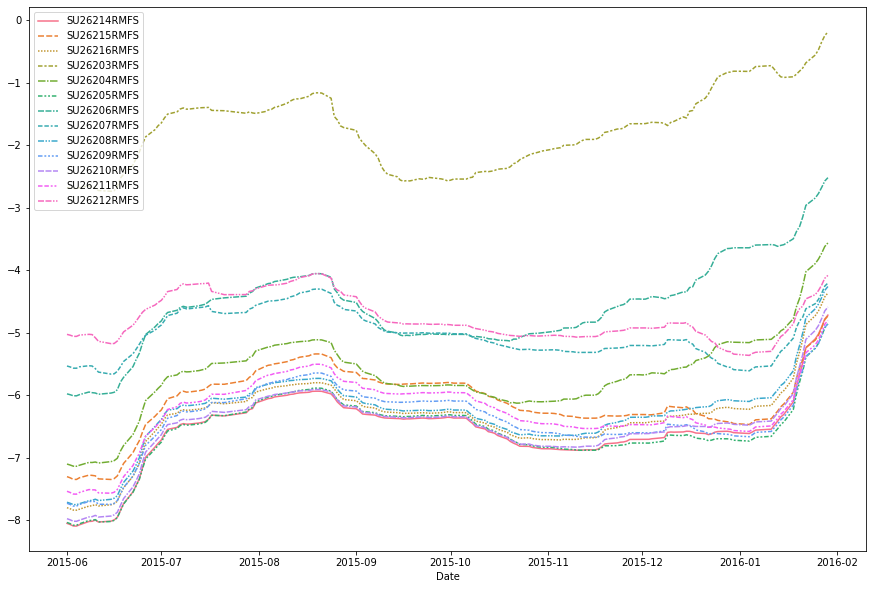

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data = coefs_df.loc['2015-06-01':'2016-01'])
plt.show()

- It can be seen that in January 2016, the regression coefficient is starting to decrease for all bond issues.

### Floating window

In [17]:
window = 45
dict_with_coefs = {}
for bond in rates.columns:
    x = df['RVI'].values
    y = df[bond].values
    coefs = []
    for i in range(window, len(x)): #at least 5 observations for regression
        model = LinearRegression()
        model.fit(x[i-window:i].reshape((-1, 1)),
                  y[i-window:i].reshape((-1, 1)))
        coefs.append(model.coef_[0][0])
    dict_with_coefs[bond] = coefs

In [18]:
coefs_df = pd.DataFrame(dict_with_coefs, index = df.Date[window:])

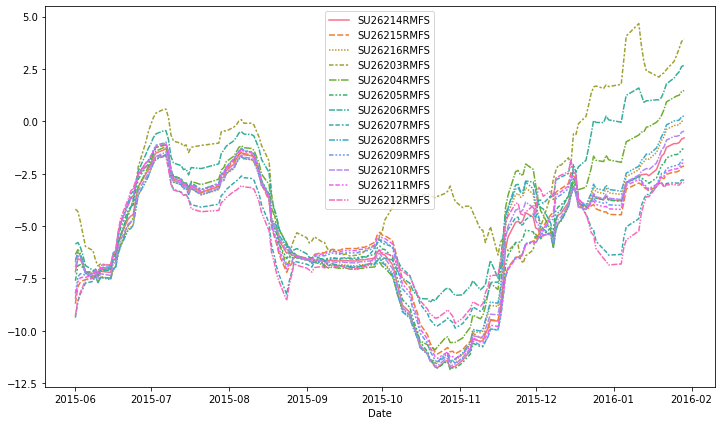

In [19]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data = coefs_df.loc['2015-06-01':'2016-01'])
plt.show()

### QLR statistics

- Let's prove our idea using the QLR method to show that in 2016-01-04 there was a structural break
- We will take OFZ 26203 as the least representative one
- Indexes since mid December

In [20]:
from chow_test import chow_test
bond = 'SU26203RMFS'
indexes = np.arange(135, len(df_train)).astype('int')
stats_f = []
p_vals = []
datee = []
for ind in indexes:
    res = chow_test(df_train['RVI'], df_train[bond], int(ind), int(ind), significance = 0.01) #Test at 1% significance
    stats_f.append(res[0])
    p_vals.append(res[1])
    datee.append(df_train.loc[int(ind)]['Date'])

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 20.85660407873729, P_value: 9.042388171565108e-09
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 19.3878904700099, P_value: 2.919505470710959e-08
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 18.433912213500513, P_value: 6.309645705915301e-08
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 18.031475895134797, P_value: 8.753372859882091e-08
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 17.476857599446923, P_value: 1.377438437755174e-07
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 17.19844432493065, P_value: 1.731161127782599e-07
Reject the null hypothesis of equality of regression coefficients in the two periods.


In [21]:
ct_info = pd.DataFrame(np.vstack((indexes, stats_f, p_vals, datee)).T, columns = ['index_number',
                                                                'Chow_stat', 'P_val', 'Date'])
ct_info.sort_values(by = 'Chow_stat', ascending=False).head(15)

,index_number,Chow_stat,P_val,Date
17,152,26.572182,0.0,2016-01-15
18,153,26.127911,0.0,2016-01-18
10,145,25.10846,0.0,2016-01-04
19,154,24.930522,0.0,2016-01-19
20,155,24.02861,0.0,2016-01-20
9,144,23.397482,0.0,2015-12-30
16,151,23.245697,0.0,2016-01-14
21,156,23.230254,0.0,2016-01-21
22,157,21.845023,0.0,2016-01-22
0,135,20.856604,0.0,2015-12-17


- Theory is proved!

## Stationarity check

- Look at the train sample.

In [22]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

In [23]:
print(f'P-value for RVI time-series on train sample, ADF test, const: {np.round(adfuller(df_train["RVI"], regression="c", autolag="AIC")[1], 3)}')
print(f'P-value for RVI time-series on train sample, KPSS test, const: {kpss(df_train["RVI"], regression="c")[1]}')
print()
print(f'P-value for RVI time-series on train sample, ADF test, const + trend : {np.round(adfuller(df_train["RVI"], regression="ct", autolag="AIC")[1], 3)}')
print(f'P-value for RVI time-series on train sample, KPSS test, const + trend: {kpss(df_train["RVI"], regression="ct")[1]}')


P-value for RVI time-series on train sample, ADF test, const: 0.1
P-value for RVI time-series on train sample, KPSS test, const: 0.1

P-value for RVI time-series on train sample, ADF test, const + trend : 0.203
P-value for RVI time-series on train sample, KPSS test, const + trend: 0.1


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next releas

## Cointegration test

In [24]:
from statsmodels.tsa.stattools import coint

In [26]:
p_vals_coint_test = [] #H0 - no cointegration
p_vals_coint_test_ct = []
for bond in rates.columns:
    p_vals_coint_test.append(coint(df_train[bond].values, df_train['RVI'].values, trend='c')[1])
    p_vals_coint_test_ct.append(coint(df_train[bond].values, df_train['RVI'].values, trend='ct')[1])
res_ts = pd.DataFrame(zip(p_vals_coint_test, p_vals_coint_test_ct), index = rates.columns, 
                      columns=['Cointegration test p-val, const', 'Cointegration test p-val, const + trend'])
res_ts.sort_index()

,"Cointegration test p-val, const","Cointegration test p-val, const + trend"
SU26203RMFS,0.080759,0.240247
SU26204RMFS,0.735997,0.852796
SU26205RMFS,0.781810,0.366297
SU26206RMFS,0.474662,0.799998
SU26207RMFS,0.751794,0.312113
SU26208RMFS,0.807733,0.756487
SU26209RMFS,0.722357,0.219871
SU26210RMFS,0.811423,0.611664
SU26211RMFS,0.577896,0.183448
SU26212RMFS,0.374106,0.312342


- almost for all bonds there's no cointegration between target and RVI